In [23]:
using Plots
using LinearAlgebra  # for diagonal matrices
using ProgressBars
using ProgressMeter

## 1) Create a thermal state

In [2]:
function thermalstate(ndims, ω, T; plotdiag::Bool=false)
    dimsrange = 1:ndims
    # Create energy eigenstates
    energies = zeros(ndims)
    for i in dimsrange
        energies[i] = exp(-ω*i/T)
    end
    energies ./= sum(energies)
    
    if plotdiag
        plt = plot(dimsrange, energies)
        display(plt)  # use display function to output 
    end

    ρ = Diagonal(energies)
end

thermalstate (generic function with 1 method)

In [3]:
# Define the dimensions of the system's Hilbert space
ndims = 25

# Define the energy of the system and its temperature
ω = 1.
T = 1.0

ρ1 = thermalstate(ndims, ω, T);
ρ2 = thermalstate(ndims, ω, T);

ρ = kron(ρ1, ρ2);

625×625 Diagonal{Float64, Vector{Float64}}:
 0.399576   ⋅         ⋅          ⋅         …   ⋅            ⋅ 
  ⋅        0.146996   ⋅          ⋅             ⋅            ⋅ 
  ⋅         ⋅        0.0540768   ⋅             ⋅            ⋅ 
  ⋅         ⋅         ⋅         0.0198937      ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅             ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅         …   ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅             ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅             ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅             ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅             ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅         …   ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅             ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅             ⋅            ⋅ 
 ⋮                                         ⋱               
  ⋅         ⋅         ⋅          ⋅             ⋅            ⋅ 
  ⋅         ⋅ 

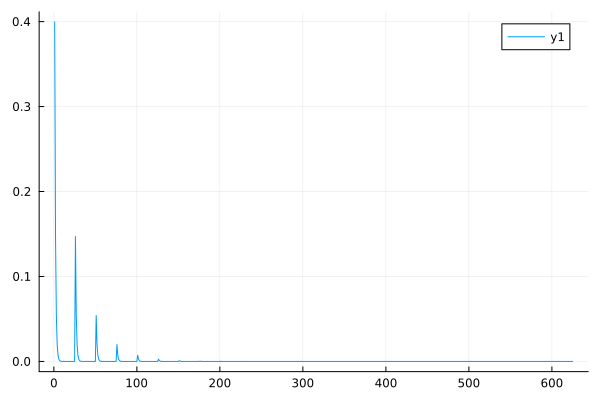

In [4]:
display(ρ)
plot(diag(ρ))

## 2) Create Phaseonium Ancillas   

In [5]:
function phaseonium(α, ϕ)
    [
        α^2 0 0;
        0 (1 - α^2)/2 (1 - α^2)/2 * exp(ϕ*im);
        0 (1 - α^2)/2 * exp(-ϕ*im) (1 - α^2)/2
    ]
end

function dissipationrates(α, ϕ)
    ga = 2*α^2
    gb = (1 + cos(ϕ))*(1 - α^2)
    return real(ga), real(gb)
end

function finaltemperature(γα, γβ)
    return - 1 / log(γα/γβ)
end

finaltemperature (generic function with 1 method)

In [6]:
# Define excited-state population of phaseonium atoms
α = 1 / 4
ϕ = 1.585589386

# Define the interaction strength
Ω = 1

# Create phaseonium density matrices
η = phaseonium(α, ϕ)

# And get dissipation rates
γα, γβ = dissipationrates(α, ϕ)

# See the final stable temperature
Tf = finaltemperature(γα, γβ)

println("Prepared Phaseonium has:\nγα = $γα,\nγβ = $γβ.\n\nIt will thermalize at temperature T = $Tf")

Prepared Phaseonium has:
γα = 0.125,
γβ = 0.9236320128073691.

It will thermalize at temperature T = 0.49999999988062405


## 3) Create Bosonic Operators

Exp, cosine and sine functions are already well-defined for matrices (they give the same results as QuTiP in Python)

In [7]:
using SparseArrays

function matrixdistance(M1, M2)
    """Calculates the Frobenius distance between two matrices
    see: https://mathworld.wolfram.com/FrobeniusNorm.html"""
    return sqrt(tr((M1-M2)*(M1-M2)'))
end

function destroy(ndims, sparseform=false)
    """Bosonic Annihilation operator"""
    elements = [sqrt(i) for i in 1:(ndims-1)]
    a = diagm(1 => elements)
    return sparseform ? sparse(a) : a
end

function create(ndims, sparseform=false)
    """Bosonic Creation operator"""
    a = destroy(ndims, sparseform)
    return a' 
end

create (generic function with 2 methods)

In [16]:
function C(θ, ndims, sparseform=true)
    a = destroy(ndims)
    argument = 2 * a * a'
    operator = cos(θ * sqrt(argument))
    return sparseform ? sparse(operator) : operator
end

function Cp(θ, ndims, sparseform=true)
    a = destroy(ndims)
    argument = 2 * a' * a
    operator = cos(θ * sqrt(argument))
    return sparseform ? sparse(operator) : operator
end

function S(θ, ndims, sparseform=true)
    a = destroy(ndims)
    argument = 2 * a * a'
    sineop = sin(θ * sqrt(argument))
    dividend = pinv(sqrt(argument))  # pseudoinverse
    operator = a' * sineop * dividend
    return sparseform ? sparse(operator) : operator
end

function Sd(θ, ndims, sparseform=true)
    s = S(θ, ndims)
    operator = s'
    return sparseform ? sparse(operator) : operator
end

Sd (generic function with 2 methods)

## 4) System Evolution

### 4.1) Define Evolution Parameters

In [18]:
dt = 1.0  # Interaction time
θ = Ω * dt  # Rabi phase

timesteps = 100;

### 4.2) Define Kraus Operators

In [19]:
E0 = sqrt(1 - γα/2 - γβ/2) * kron(I(ndims), I(ndims))
E1 = sqrt(γα/2) * ( kron(C(θ, ndims), C(θ, ndims)) -2 * kron(S(θ, ndims), Sd(θ, ndims)) )
E2 = sqrt(γα) * ( kron(S(θ, ndims), Cp(θ, ndims)) + kron(C(θ, ndims), S(θ, ndims)) )
E3 = sqrt(γβ) * ( kron(Sd(θ, ndims), C(θ, ndims)) + kron(Cp(θ, ndims), Sd(θ, ndims)) )
E4 = sqrt(γβ/2) * ( kron(Cp(θ, ndims), Cp(θ, ndims)) -2 * kron(Sd(θ, ndims), S(θ, ndims)) )
kraus = (E0, E1, E2, E3, E4);

In [20]:
println("Percentage of zeros in Kraus Operators")
for ek in kraus
    num_zeros = count(iszero, ek)
    sparsity = num_zeros / length(ek)
    println("- $sparsity")
end

Percentage of zeros in Kraus Operators
- 0.9984
- 0.99692544
- 0.996928
- 0.996928
- 0.99692544


### 4.3) Write Equations of Motion

In [134]:
using CUDA

function D(M, ρ)
    """Dissipator Operator appearing in the Master Equation"""
    sandwich = M * ρ * M'
    commutator = M' * M * ρ + ρ * M' * M
    return sandwich - 1/2 * commutator    
end

function meqevolve(ρ, kraus, timesteps)
    Δρ = zeros(size(ρ))
    for t in 1:timesteps
        for Ek in kraus[2:length(kraus)]
            Δρ += D(Ek, ρ)
        end
        ρ += Δρ
    end
    return ρ
end

function krausevolve(ρ, kraus, timesteps)
    old = ρ
    dimensions = size(ρ)
    temp1 = zeros(dimensions)
    temp2 = zeros(dimensions)
    @showprogress for i in 1:timesteps
        # Reset the new density operator
        new = zeros(dimensions)
        for ek in kraus
            mul!(temp1, ek, old)  # left multiplication
            mul!(temp2, temp1, ek')  # right multiplication
            new .+= temp2
        end
        old = new  # updates the old density operator
    end
    return old
end

krausevolve (generic function with 1 method)

In [74]:
a = [["a","b"], ["c","d"], ["e","f"]]
for (i, (l, r)) in zip(1:5, a)
    println(l)
end
a

a
c
e


3-element Vector{Vector{String}}:
 ["a", "b"]
 ["c", "d"]
 ["e", "f"]

### 4.4) Do some Benchmark

In [13]:
using BenchmarkTools

ρt = ρ;

In [15]:
b1 = @benchmarkable krausevolve(ρt, kraus, 10000)
tune!(b1)
run(b1)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 568.947 s (0.35% GC) to evaluate,
 with a memory estimate of 29.11 GiB, over 70005 allocations.

In [135]:
ρt = ρ;
ρt = krausevolve(ρt, kraus, 5000);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


## 5) Results

In [28]:
function chop!(matrix, threshold = 1e-8)
    """Set small elements to zero"""
    matrix[abs.(matrix) .< threshold] .= 0
end

chop!(ρt);

In [29]:
function isdiagonal(mat::Matrix)
    return mat == Diagonal(diag(mat))
end


function ispositive(mat::Matrix)
    return all(mat .>= 0)
end


function isnormal(mat::Matrix; threshold = 1e-5)
    return tr(mat) - 1 < threshold
end


function canbecut(mat::Matrix, threshold = 1e-5)
    """Check if the last element of the matrix is really small so we can truncate the hilbert space"""
    return last(diag(mat)) < threshold
end


function checkdensity(mat::Matrix)
    println("""
        Diagonal: $(isdiagonal(mat))
        Positive: $(ispositive(mat))
        Normal: $(isnormal(mat))
        Truncatable: $(canbecut(mat))
        """)
    return ispositive(mat) && isnormal(mat) && canbecut(mat)
end

checkdensity(ρt)

Diagonal: false
Positive: false
Normal: true
Truncatable: true



false

In [30]:
indices = findall(x -> x <0, ρt)
println(length(indices))
ρt[indices[100]]

100


-2.1476123464570522e-8

In [31]:
function partial_trace(ρ, ndims, subsystem)
    # Reshape the density matrix into a 4D tensor
    rho_tensor = reshape(ρ, (ndims, ndims, ndims, ndims))

    if subsystem == 1
        # Take the partial trace over s2
        rho_subsystem = [tr(rho_tensor[i, :, j, :]) for i in 1:ndims, j in 1:ndims]
    elseif subsystem == 2
        # Take the partial trace over s1
        rho_subsystem = [tr(rho_tensor[:, i, :, j]) for i in 1:ndims, j in 1:ndims]
    else
        error("Invalid subsystem. Choose either '1' or '2'.")
    end

    return rho_subsystem
end

ρ1 = partial_trace(ρt, ndims, 1)
ρ2 = partial_trace(ρt, ndims, 2)
checkdensity(ρ1)

Diagonal: true
Positive: true
Normal: true
Truncatable: true



true

0.5000117241941292

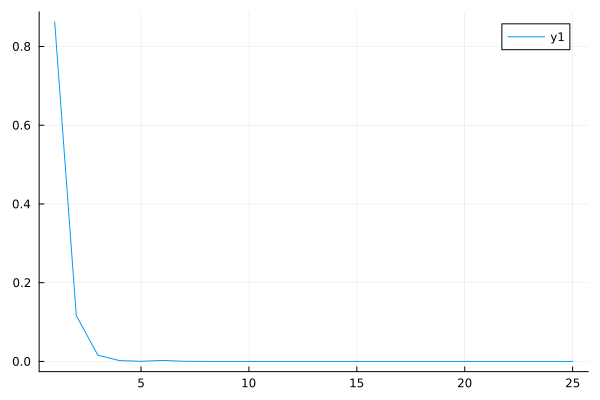

In [33]:
ρ00 = diag(ρ1)[1]
ρ11 = diag(ρ1)[2]
Tstable = - 1 / log(ρ11 / ρ00)
display(Tstable)
plot(diag(ρ2))